In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}

background_classes = {'cat', 'deer', 'dog', 'frog', 'horse','ship', 'truck'}

fg1,fg2,fg3 = 0,1,2

In [5]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [6]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]- fg1  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [7]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)

In [8]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 125
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 12, 5)
    self.conv3 = nn.Conv2d(12,20,5)
    self.fc1 = nn.Linear(20 * 6 * 6, 120)
    self.fc2 = nn.Linear(120, 80)
    self.fc3 = nn.Linear(80, 40)
    self.fc4 = nn.Linear(40,10)
    self.fc5 = nn.Linear(10,1)

  def forward(self,z):  #y is avg image #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = y.to("cuda")
    x = x.to("cuda")
    
    for i in range(9):
        x[:,i] = self.helper(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])

    return x, y

  def helper(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = (F.relu(self.conv2(x)))
    x = (F.relu(self.conv3(x)))
    x = x.view(-1, 20 * 6 * 6)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return x

In [42]:
focus_net = Focus().double()
focus_net = focus_net.to("cuda")

In [43]:
import torch.nn as nn
import torch.nn.functional as F
class Classify_net(nn.Module):
  def __init__(self):
    super(Classify_net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 12, 5)
    self.conv3 = nn.Conv2d(12,20,5)
    self.fc1 = nn.Linear(20 * 6 * 6, 120)
    self.fc2 = nn.Linear(120, 80)
    self.fc3 = nn.Linear(80, 40)
    self.fc4 = nn.Linear(40,10)
    self.fc5 = nn.Linear(10,3)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = (F.relu(self.conv2(x)))
    x = (F.relu(self.conv3(x)))
    x = x.view(-1, 20 * 6 * 6)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return x

In [44]:
classify = Classify_net().double()
classify = classify.to("cuda")

In [45]:
classify.load_state_dict( torch.load("/content/drive/My Drive/Research/Cheating_data/Classify_net_weights/classify_net"+"cnn"+".pt"))

<All keys matched successfully>

In [46]:
for params in classify.parameters():
  params.requires_grad = False

In [47]:
for params in classify.parameters():
  print(params)
  break;

Parameter containing:
tensor([[[[-1.6423e-01,  1.7392e-01,  4.9897e-01,  6.2711e-01,  1.2254e-01],
          [ 2.4849e-02,  2.6886e-02,  2.0595e-01,  1.3431e-01, -3.6509e-01],
          [-2.9908e-01, -3.2545e-01, -2.9668e-01, -4.8356e-01, -4.4245e-01],
          [-2.4543e-01, -1.0781e-01, -1.7590e-02, -4.7907e-02,  1.1002e-02],
          [ 3.0143e-02,  2.1096e-01,  2.2314e-01,  9.1594e-02,  3.0036e-01]],

         [[-5.8768e-02,  1.3975e-01,  4.1226e-01,  2.7912e-01, -2.2264e-01],
          [ 6.7200e-02,  6.1176e-02,  1.6692e-01, -1.2179e-01, -4.3682e-01],
          [-8.4766e-02, -3.5242e-01, -4.1281e-01, -4.5495e-01, -6.1057e-01],
          [-1.2020e-01, -4.3536e-02,  9.0031e-02,  1.8540e-02,  1.1777e-01],
          [ 2.2654e-01,  4.0664e-01,  4.5058e-01,  2.0680e-01,  1.6883e-01]],

         [[ 2.7177e-02,  1.1304e-01,  2.0884e-01,  3.8100e-01, -4.7785e-02],
          [ 2.1222e-01,  2.1781e-01,  1.4267e-01,  1.3736e-01, -2.5502e-01],
          [-2.2782e-01, -3.3184e-01, -3.4972e-01, 

In [48]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [49]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [50]:
import torch.optim as optim
criterion_focus = nn.CrossEntropyLoss()
optimizer_focus = optim.SGD(focus_net.parameters(), lr=0.01, momentum=0.9)

In [51]:
nos_epochs = 200
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion_focus(outputs, labels) 
    loss.backward()
    optimizer_focus.step()

    running_loss += loss.item()
    mini = 60
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1
    
    if epoch % 5 == 0:
      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

  if(np.mean(epoch_loss) <= 0.03):
      break;

  if epoch % 5 == 0:
    col1.append(epoch)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
  
    #************************************************************************
    #testing data set  
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        alphas, avg_images = focus_net(inputs)
        outputs = classify(avg_images)
        _, predicted = torch.max(outputs.data, 1)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    # torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/CIFAR Mosaic/weights/model_epoch"+str(epoch)+".pt")
    
print('Finished Training')
# torch.save(fore_net.state_dict(),"/content/drive/My Drive/Research/CIFAR Mosaic/weights/model_epoch"+str(nos_epochs)+".pt")

[1,    60] loss: 7.700
[1,   120] loss: 4.819
[1,   180] loss: 5.928
[1,   240] loss: 7.234
[2,    60] loss: 7.171
[2,   120] loss: 7.486
[2,   180] loss: 7.535
[2,   240] loss: 7.573
[3,    60] loss: 7.430
[3,   120] loss: 7.466
[3,   180] loss: 7.583
[3,   240] loss: 7.464
[4,    60] loss: 7.455
[4,   120] loss: 7.654
[4,   180] loss: 7.498
[4,   240] loss: 7.575
[5,    60] loss: 7.666
[5,   120] loss: 7.564
[5,   180] loss: 7.415
[5,   240] loss: 7.537
[6,    60] loss: 7.656
[6,   120] loss: 7.530
[6,   180] loss: 7.689
[6,   240] loss: 7.750
[7,    60] loss: 7.794
[7,   120] loss: 7.579
[7,   180] loss: 7.629
[7,   240] loss: 7.786
[8,    60] loss: 7.664
[8,   120] loss: 7.681
[8,   180] loss: 7.734
[8,   240] loss: 7.709
[9,    60] loss: 7.671
[9,   120] loss: 7.693
[9,   180] loss: 7.744
[9,   240] loss: 7.680
[10,    60] loss: 7.814
[10,   120] loss: 7.736
[10,   180] loss: 7.593
[10,   240] loss: 7.646
[11,    60] loss: 7.653
[11,   120] loss: 7.731
[11,   180] loss: 7.778
[11,

In [20]:
for params in classify.parameters():
  print(params)
  break;

Parameter containing:
tensor([[[[-1.6423e-01,  1.7392e-01,  4.9897e-01,  6.2711e-01,  1.2254e-01],
          [ 2.4849e-02,  2.6886e-02,  2.0595e-01,  1.3431e-01, -3.6509e-01],
          [-2.9908e-01, -3.2545e-01, -2.9668e-01, -4.8356e-01, -4.4245e-01],
          [-2.4543e-01, -1.0781e-01, -1.7590e-02, -4.7907e-02,  1.1002e-02],
          [ 3.0143e-02,  2.1096e-01,  2.2314e-01,  9.1594e-02,  3.0036e-01]],

         [[-5.8768e-02,  1.3975e-01,  4.1226e-01,  2.7912e-01, -2.2264e-01],
          [ 6.7200e-02,  6.1176e-02,  1.6692e-01, -1.2179e-01, -4.3682e-01],
          [-8.4766e-02, -3.5242e-01, -4.1281e-01, -4.5495e-01, -6.1057e-01],
          [-1.2020e-01, -4.3536e-02,  9.0031e-02,  1.8540e-02,  1.1777e-01],
          [ 2.2654e-01,  4.0664e-01,  4.5058e-01,  2.0680e-01,  1.6883e-01]],

         [[ 2.7177e-02,  1.1304e-01,  2.0884e-01,  3.8100e-01, -4.7785e-02],
          [ 2.1222e-01,  2.1781e-01,  1.4267e-01,  1.3736e-01, -2.5502e-01],
          [-2.2782e-01, -3.3184e-01, -3.4972e-01, 

In [52]:
torch.save(classify.state_dict(),"/content/drive/My Drive/Research/Cheating_data/final_attention_weights/train_focus_cnn_cheat_classify_cnn"+".pt")

In [53]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]

In [54]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [55]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [56]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,7562,22438,2210,9309,2357,16124
1,5,30000,0,2177,9077,0,18746
2,10,30000,0,2162,9097,0,18741
3,15,30000,0,2162,9097,0,18741
4,20,30000,0,2162,9097,0,18741
5,25,30000,0,2162,9097,0,18741
6,30,30000,0,2162,9097,0,18741
7,35,30000,0,2162,9097,0,18741
8,40,30000,0,2162,9097,0,18741
9,45,30000,0,2162,9097,0,18741


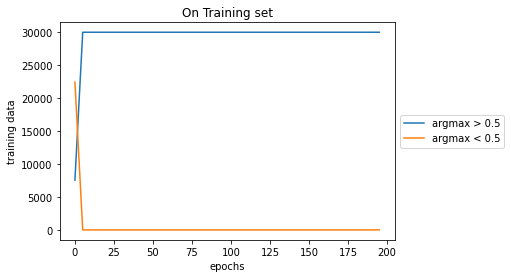

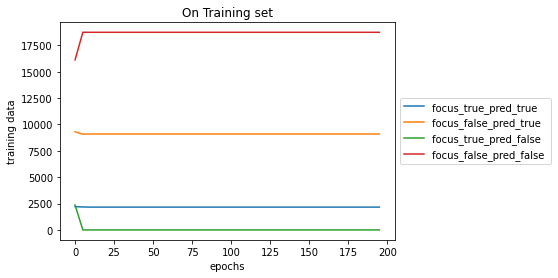

In [57]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.show()

In [58]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,10000,0,660,3094,0,6246
1,5,10000,0,762,3095,0,6143
2,10,10000,0,762,3095,0,6143
3,15,10000,0,762,3095,0,6143
4,20,10000,0,762,3095,0,6143
5,25,10000,0,762,3095,0,6143
6,30,10000,0,762,3095,0,6143
7,35,10000,0,762,3095,0,6143
8,40,10000,0,762,3095,0,6143
9,45,10000,0,762,3095,0,6143


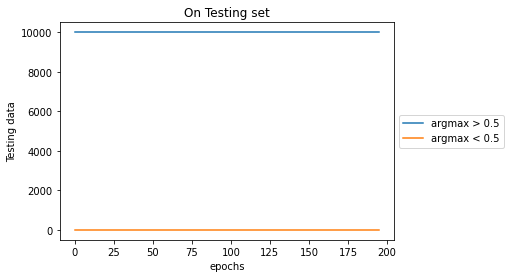

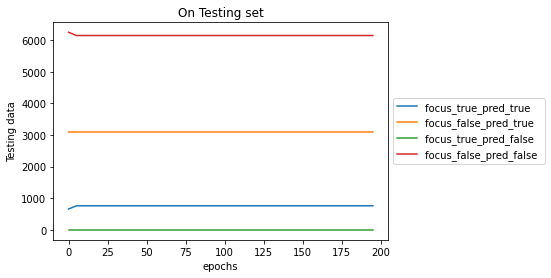

In [59]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.show()

In [60]:
correct = 0
total = 0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 30000 train images: 37 %
total correct 11259
total train set images 30000


In [61]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 38 %
total correct 3857
total train set images 10000
